In [4]:
from mnist import MNIST

mndata = MNIST('/home/satyake/Downloads/weatherman')
mndata.gz=True

x_train, y_train = mndata.load_training()
# or
mndata1=MNIST('/home/satyake/Downloads/weatherman')
mndata1.gz=True
x_test,y_test=mndata1.load_testing()
y_train=np.array(y_train)
y_test=np.array(y_test)



75

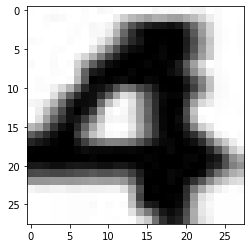

In [5]:
plt.imshow(np.reshape(x_train[31],(28,28)),cmap='binary')
len(x_test)

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import random
from pca_plotter import PCAPlotter
import tensorflow as tf

In [7]:
def plot_triplet(data):
    plt.figure(figsize=(6,3))
    for i in range(0,3):
        plt.subplot(1,3,i+1)
        plt.imshow(np.reshape(data[i],(28,28)),cmap='gray')
    plt.show()
    
    

In [23]:
#Batch Generator
def create_batch(batch_size):
    anchors=np.zeros((batch_size,784))
    positives=np.zeros((batch_size,784))
    negatives=np.zeros((batch_size,784))
    
    for i in range(0,batch_size):
            index=random.randint(0,len(x_train)-1)
            anc=x_train[index]
            label_of_anc=y_train[index]
            indices_of_pos=np.squeeze(np.where(y_train==label_of_anc))
            indices_of_neg=np.squeeze(np.where(y_train!=label_of_anc))
            #print(indices_of_pos)
            pos=x_train[indices_of_pos[random.randint(0,len(indices_of_pos)-1)]]
            neg=x_train[indices_of_neg[random.randint(0,len(indices_of_neg)-1)]]
            positives[i]=pos
            negatives[i]=neg
            anchors[i]=anc
    return [anchors,positives,negatives]

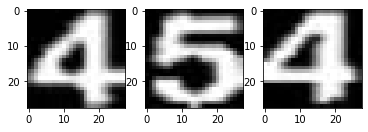

In [24]:
plot_triplet([x_train[0],x_train[1],x_train[4]])  #testing the triplet plot

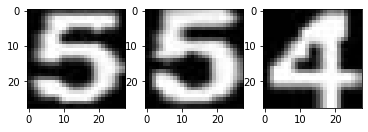

In [25]:
files=create_batch(1)
plot_triplet(files) #CHECKING THE BATCHGENFUNCTION

In [26]:
random.randint(0,32)

20

In [27]:
input_shape=np.reshape(image)

NameError: name 'image' is not defined

In [28]:
#CREATE EMBEDDING MODEL
emb_dim=64
embedding_model=tf.keras.Sequential([tf.keras.layers.Dense(64,activation='relu',input_shape=(784,)),
                                     tf.keras.layers.Dense(64,activation='sigmoid')])

in_anc=tf.keras.layers.Input(shape=(784,))
in_pos=tf.keras.layers.Input(shape=(784,))
in_neg=tf.keras.layers.Input(shape=(784,))
emb_anc=embedding_model(in_anc) #apply the model to the anchor,positive and negatives
emb_pos=embedding_model(in_pos)
emb_neg=embedding_model(in_neg)
out=tf.keras.layers.concatenate([emb_anc,emb_pos,emb_neg],axis=1)
Network=tf.keras.models.Model([in_anc,in_pos,in_neg],out)

In [29]:
embedding_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [30]:
Network.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           54400       input_4[0][0]                    
                                                                 input_5[0][0]              

In [31]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

[1.00000000e+00 1.00000000e+00 0.00000000e+00 1.36201250e-12
 1.00000000e+00 0.00000000e+00 2.59446742e-10 9.68766551e-33
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.28245758e-32
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 2.16683403e-20 1.00000000e+00 1.00000000e+00
 0.00000000e+00 9.99789298e-01 1.13826585e-21 1.00000000e+00
 9.99994874e-01 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.88146842e-01 1.00000000e+00 1.00000000e+00 1.00331845e-19
 1.00000000e+00 5.28471039e-30 0.00000000e+00 7.09321385e-27
 1.00000000e+00 9.79804277e-01 4.74053031e-29 1.00000000e+00
 1.96801191e-32 1.00000000e+00 5.58396304e-29 5.63381946e-05
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.93169170e-33]


In [32]:
def data_generator(batch_size,emb_dim):
    while True:
        x=create_batch(batch_size)
        y=np.zeros((batch_size,3*emb_dim))
        yield x,y

In [18]:
print(data_generator(1,emb_dim))

<generator object data_generator at 0x7f1052cbd9d0>


In [33]:
#Triplet Loss Function Defined
def loss(y_true,y_pred):
        anc=y_pred[:,:emb_dim]
        pos=y_pred[:,emb_dim:2*emb_dim]
        neg=y_pred[:,2*emb_dim:]
        dp=tf.reduce_mean(tf.square(anc-pos),axis=1)
        dn=tf.reduce_mean(tf.square(anc-neg),axis=1)
        return tf.maximum(dp-dn+0.2,0.)
        

In [34]:
batch_size=1
epochs=10
steps_per_epoch=2
Network.compile(loss=loss,optimizer='adam')
X,Y=x_test[:74],y_test[:74]

In [288]:
#x_test[:74]

  ...
    to  
  ['...']


/home/satyake/pca_plotter.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


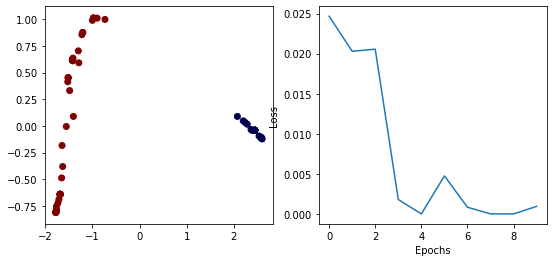

In [35]:
_ = Network.fit_generator(
    data_generator(batch_size,emb_dim),
    steps_per_epoch=15,
    epochs=epochs, verbose=False,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:74], y_test[:74]
        )]
)

  ...
    to  
  ['...']


/home/satyake/pca_plotter.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


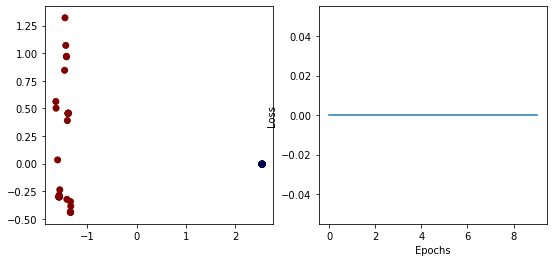

In [ ]:
y_train
y_train=np.array(y_train)

In [105]:
z=[]
for i in y_train:
    if i==3:
      z.append(i)
      

In [109]:
a=[1,2,3,4,5,3,3,6,7]
a=np.array(a)

np.where(a==3)

(array([2, 5, 6]),)